# Imaging notebook

This notebook works through the high level functions interface to crocodile, making a fake data set and then
deconvolving it. Finally the full and residual visibility are plotted.

In [4]:
%matplotlib inline

import sys, os 
sys.path.append('../..') 
print(os.getcwd())

import pylab
pylab.rcParams['figure.figsize'] = (12.0, 12.0)
pylab.rcParams['image.cmap'] = 'rainbow'

from astropy import constants as const
from astropy import units as u
from astropy.coordinates import SkyCoord, CartesianRepresentation, SkyOffsetFrame
import scipy.special

from matplotlib import pylab
from matplotlib import pyplot as plt

from functions.clean import clean
from functions.visibility import create_visibility
from functions.imaging import *
from functions.skymodel import SkyModel, skymodel_from_image, skymodel_add_image, skymodel_add_component
from functions.skycomponent import *
from functions.image import image_show, image_from_fits, image_to_fits, image_replicate, fitcomponent
from functions.configuration import configuration_filter, named_configuration

/Users/timcornwell/Code/crocodile/examples/notebooks


We construct a VLA configuration and then shrink it to match our test image.

In [5]:
kwargs = {}

vlaa = configuration_filter(named_configuration('VLAA'), **kwargs)
vlaa.data['xyz']=vlaa.data['xyz']/10.0

Configuration: No filter implemented yet


We create the visibility. This just makes the uvw, time, antenna1, antenna2, weight columns in a table

In [6]:
times = numpy.arange(-numpy.pi/2.0, +numpy.pi/2.0,0.05)
frequency = numpy.array([1e8])

reffrequency = numpy.max(frequency)
phasecentre = SkyCoord(0.0*u.rad, u.rad*numpy.pi/4, frame='icrs', equinox=2000.0)
vt = create_visibility(vlaa, times, frequency, weight=1.0, phasecentre=phasecentre)

visibility.create_visibility: Created 22113 rows


Plot the synthesized uv coverage, including for MFS

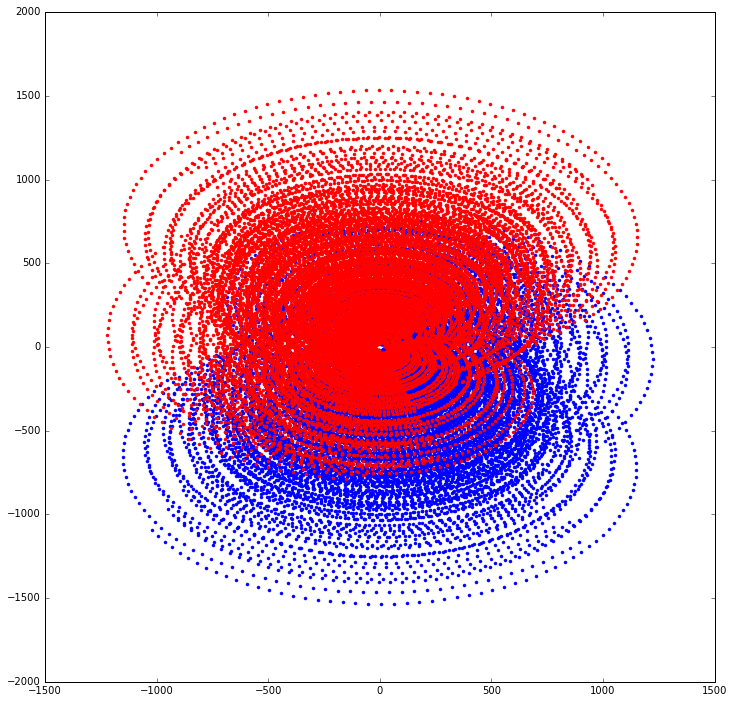

In [7]:
plt.clf()
for f in frequency:
    x=f/const.c
    plt.plot(x*vt.data['uvw'][:,0], x*vt.data['uvw'][:,1], '.', color='b')
    plt.plot(-x*vt.data['uvw'][:,0], -x*vt.data['uvw'][:,1], '.', color='r')

Read the venerable test image, constructing an image

image_from_fits: Max, min in /Users/timcornwell/Code/crocodile//./data/models/M31.MOD = 1.006458, -0.000000


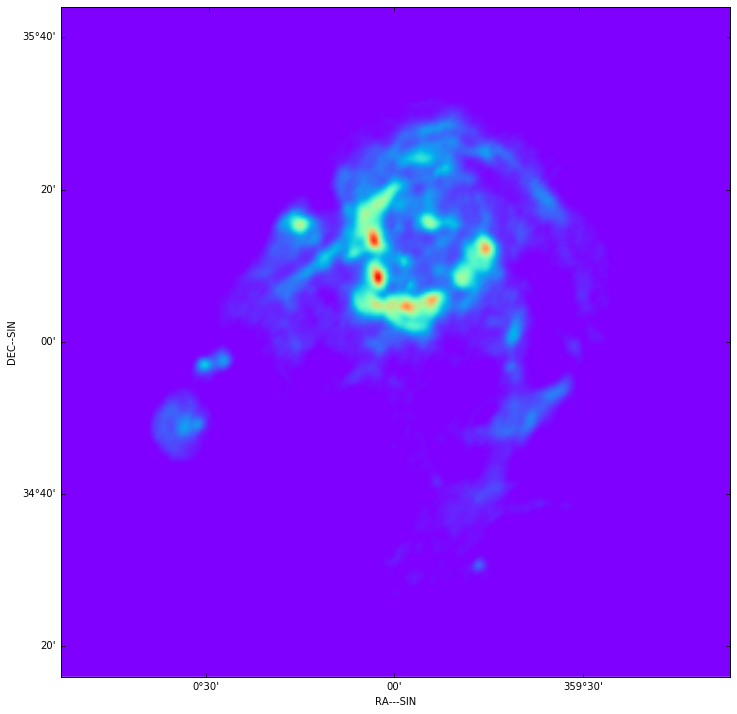

In [8]:
m31image = image_from_fits("./data/models/M31.MOD")
fig = plt.figure()
cellsize=180.0*0.0001/numpy.pi
m31image.wcs.wcs.cdelt[0]=-cellsize
m31image.wcs.wcs.cdelt[1]=+cellsize
m31image.wcs.wcs.radesys='ICRS'
m31image.wcs.wcs.equinox=2000.00


fig.add_subplot(111, projection=m31image.wcs)
plt.imshow(m31image.data, origin='lower', cmap='rainbow')
plt.xlabel('RA---SIN')
plt.ylabel('DEC--SIN')
plt.show()

In [9]:
from astropy.wcs.utils import skycoord_to_pixel, pixel_to_skycoord
wall = m31image.wcs
wall.wcs.radesys='ICRS'
wall.wcs.equinox=2000.00
print(wall.wcs.radesys)
print(wall.wcs.equinox)
sc=pixel_to_skycoord(128, 128, wall, 1, 'wcs')
print(sc)
pixloc = skycoord_to_pixel(SkyCoord("-1.0d", "37.0d", frame='icrs', equinox=2000.0), wall, 1)
print(pixloc)
scrt = pixel_to_skycoord(pixloc[0], pixloc[1], wall, 1, 'wcs')
print(scrt)

ICRS
2000.0
<SkyCoord (ICRS): (ra, dec) in deg
    (0.0, 35.0)>
(array(267.38111516593335), array(477.69264278296))
<SkyCoord (ICRS): (ra, dec) in deg
    (359.0, 37.0)>


In [10]:
sof=sc.skyoffset_frame()

This image is only 2 dimensional. We need extra axes frequency and stokes. 

In [11]:
m31image4D=image_replicate(m31image, shape=[1, 1, 4, len(frequency)])
m31sm = skymodel_from_image(m31image4D)

image_replicate: replicating shape (256, 256) to (1, 4, 256, 256)
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---SIN'  'DEC--SIN'  
CRVAL : 0.0  35.0  
CRPIX : 128.0  128.0  
NAXIS    : 256 256


Add some SkyComponents

In [12]:
comp1=SkyComponent(SkyCoord("05d00m00.0s", "02d00m0.0s"), numpy.array([[1.0,0.0,0.0,0.0]]), frequency)
m31sm=skymodel_add_component(m31sm, comp1)

Now we can predict the visibility from this model

In [13]:
kwargs={'wstep':100.0, 'npixel':256, 'cellsize':0.0001}
vt = predict(vt, m31sm, **kwargs)

imaging.wcs_from_visibility: Parsing kwargs to get definition of WCS
imaging.wcs_from_visibility: Defining Image at <SkyCoord (ICRS): (ra, dec) in deg
    (0.0, 45.0)>, frequency 100000000.0 Hz, and bandwidth 100000000.0 Hz
imaging.wcs_from_visibility: uvmax = 1533.754509 lambda
imaging.wcs_from_visibility: Critical cellsize = 0.000326 radians, 0.018678 degrees
imaging.wcs_from_visibility: Cellsize          = 0.000100 radians, 0.005730 degrees
imaging.predict: Predicting Visibility from sky model images
imaging.predict: Image cellsize 0.000100 radians
imaging.predict: Field of view 0.025600 radians
imaging.predict: Making w-kernel cache of 12 kernels
imaging.predict: Predicting from image channel 0, polarisation 0
imaging.predict: Predicting from image channel 0, polarisation 1
imaging.predict: Predicting from image channel 0, polarisation 2
imaging.predict: Predicting from image channel 0, polarisation 3
imaging.predict: Finished predicting Visibility from sky model images
imaging.pre

To check that we got it right, plot the amplitude of the visibility.

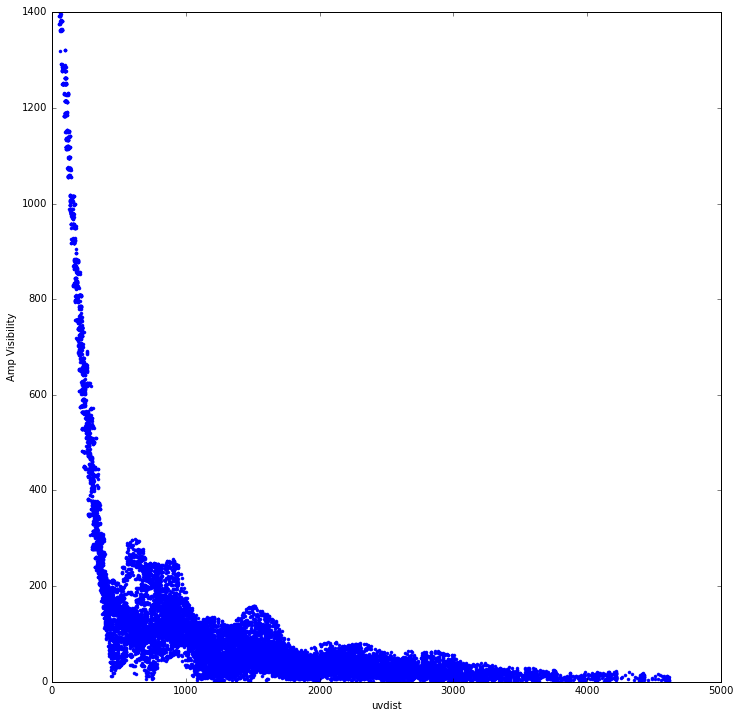

In [14]:
uvdist=numpy.sqrt(vt.data['uvw'][:,0]**2+vt.data['uvw'][:,1]**2)
plt.clf()
plt.plot(uvdist, numpy.abs(vt.data['vis'][:,0,0]), '.')
plt.xlabel('uvdist')
plt.ylabel('Amp Visibility')
plt.show()

Make the dirty image and point spread function

imaging.invert: Inverting Visibility to make dirty and psf
imaging.wcs_from_visibility: Parsing kwargs to get definition of WCS
imaging.wcs_from_visibility: Defining Image at <SkyCoord (ICRS): (ra, dec) in deg
    (0.0, 45.0)>, frequency 100000000.0 Hz, and bandwidth 100000000.0 Hz
imaging.wcs_from_visibility: uvmax = 1533.754509 lambda
imaging.wcs_from_visibility: Critical cellsize = 0.000326 radians, 0.018678 degrees
imaging.wcs_from_visibility: Cellsize          = 0.000100 radians, 0.005730 degrees
imaging.invert: Specified npixel=512, cellsize = 0.000100 rad, FOV = 0.051200 rad
imaging.invert: Making w-kernel cache of 39 kernels
imaging.invert: Inverting channel 0, polarisation 0
imaging.invert: Inverting channel 0, polarisation 1
imaging.invert: Inverting channel 0, polarisation 2
imaging.invert: Inverting channel 0, polarisation 3
imaging.invert: Finished making dirty and psf
Max, min in dirty image = 20.834159, -1.182864, sum of weights = 0.038254
Max, min in PSF         = 1.000

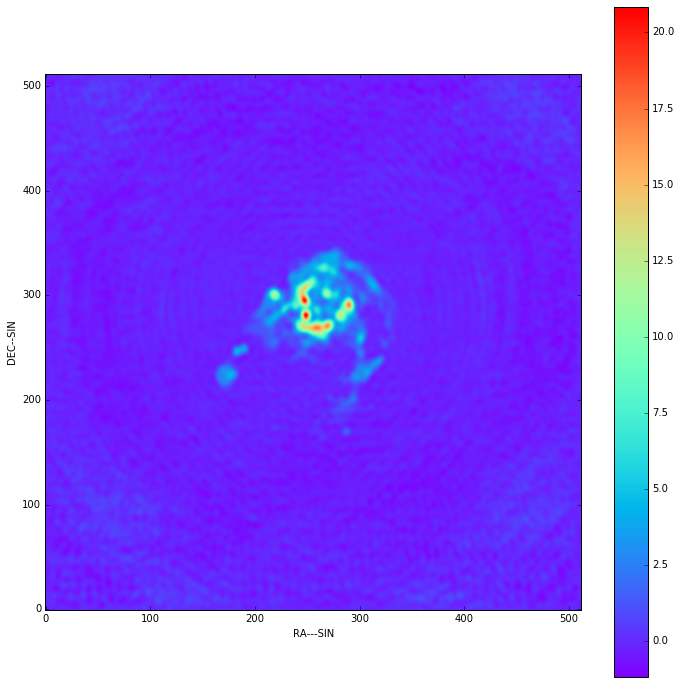

In [15]:
kwargs={}
kwargs['npixel']=512
kwargs['cellsize']=0.0001
kwargs['wstep']=30.0
dirty, psf, sumwt = invert(vt, **kwargs)
image_show(dirty)
print("Max, min in dirty image = %.6f, %.6f, sum of weights = %f" % (dirty.data.max(), dirty.data.min(), sumwt))

print("Max, min in PSF         = %.6f, %.6f, sum of weights = %f" % (psf.data.max(), psf.data.min(), sumwt))

image_to_fits(dirty, 'dirty.fits')
image_to_fits(psf, 'psf.fits')
m31compnew = fitcomponent(dirty, **kwargs)

In [16]:
kwargs={'niter':100, 'threshold':0.001, 'fracthresh':0.01}
comp, residual = clean(dirty, psf, **kwargs)

clean.clean: Processing pol 0, channel 0
Peak of PSF = 1.0 at (256, 256)
Peak of Dirty = 20.8304699614 at (281, 248)
Coupling matrix =
 [[ 1.          0.98254714  0.76027592  0.19824986]
 [ 0.98254714  0.96555194  0.74886582  0.19720193]
 [ 0.76027592  0.74886582  0.60082915  0.18228196]
 [ 0.19824986  0.19720193  0.18228196  0.10628513]]
Max abs in dirty Image = 20.830470
Start of minor cycle
This minor cycle will stop at 100 iterations or peak < 0.208304699614
Minor cycle 0, peak [ 17.1773213   17.11512866  16.26266858  12.36699409] at [268, 260, 3]
Minor cycle 10, peak [ 7.63699723  7.60475983  7.16507548  5.46885748] at [326, 267, 3]
Minor cycle 20, peak [ 4.31031829  4.28856364  3.99522116  2.90421978] at [279, 218, 3]
Minor cycle 30, peak [ 4.30779614  4.28298409  3.91903641  1.9789742 ] at [247, 185, 3]
Minor cycle 40, peak [ 3.56377334  3.52522306  3.03003595  1.6111026 ] at [291, 240, 3]
Minor cycle 50, peak [ 2.3530902   2.33627143  2.10906927  1.2374973 ] at [247, 299, 3]
Mi

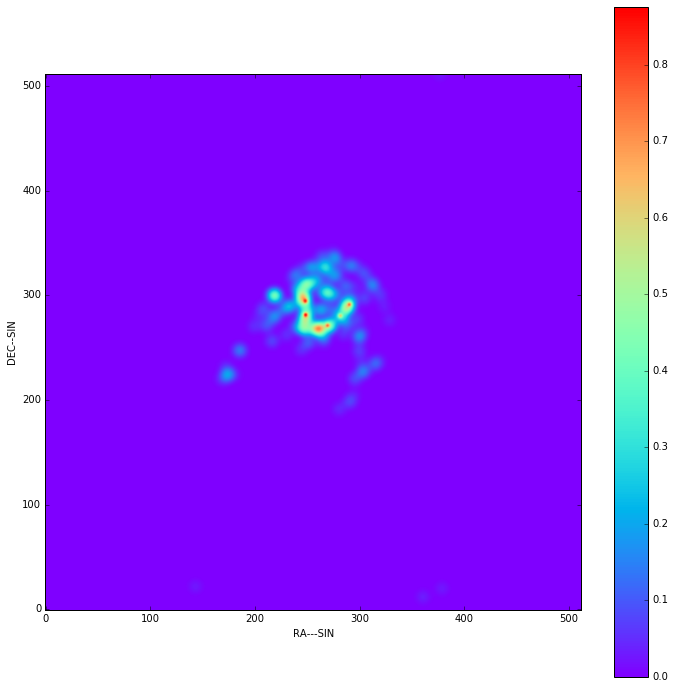

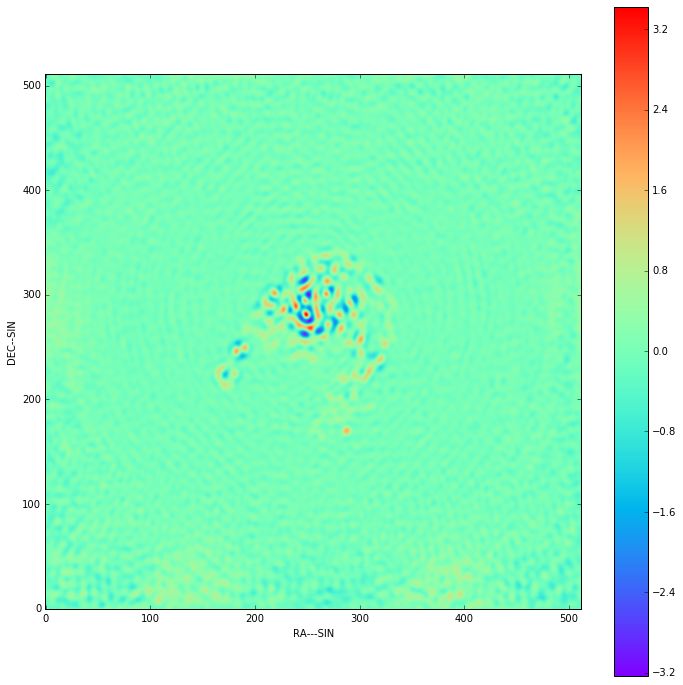

In [17]:
fig=image_show(comp)
fig=image_show(residual)

In [18]:
kwargs={'wstep':30.0}
vt = predict(vt, m31sm, **kwargs)
modelsm=skymodel_from_image(comp)
vtmodel = create_visibility(vlaa, times, frequency, weight=1.0, phasecentre=phasecentre)
vtmodel.data = vt.data.copy()
vtmodel=predict(vtmodel, modelsm,**kwargs)

imaging.wcs_from_visibility: Parsing kwargs to get definition of WCS
imaging.wcs_from_visibility: Defining Image at <SkyCoord (ICRS): (ra, dec) in deg
    (0.0, 45.0)>, frequency 100000000.0 Hz, and bandwidth 100000000.0 Hz
imaging.wcs_from_visibility: uvmax = 1533.754509 lambda
imaging.wcs_from_visibility: Critical cellsize = 0.000326 radians, 0.018678 degrees
imaging.wcs_from_visibility: Cellsize          = 0.000163 radians, 0.009339 degrees
imaging.predict: Predicting Visibility from sky model images
imaging.predict: Image cellsize 0.000100 radians
imaging.predict: Field of view 0.025600 radians
imaging.predict: Making w-kernel cache of 39 kernels
imaging.predict: Predicting from image channel 0, polarisation 0
imaging.predict: Predicting from image channel 0, polarisation 1
imaging.predict: Predicting from image channel 0, polarisation 2
imaging.predict: Predicting from image channel 0, polarisation 3
imaging.predict: Finished predicting Visibility from sky model images
imaging.pre

Now we will plot the original visibility and the residual visibility.

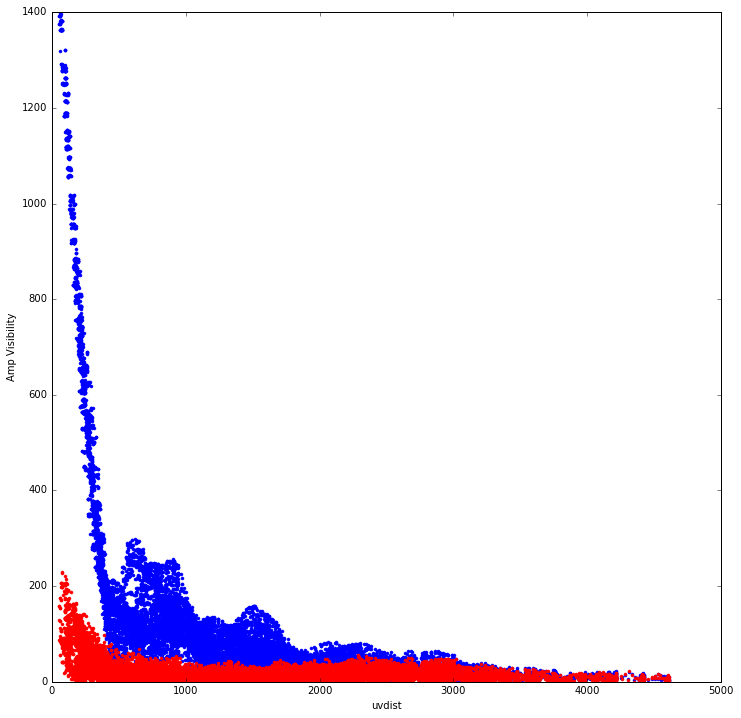

In [19]:
uvdist=numpy.sqrt(vt.data['uvw'][:,0]**2+vt.data['uvw'][:,1]**2)
plt.clf()
plt.plot(uvdist, numpy.abs(vt.data['vis'][:,0,0]), '.', color='b')
plt.plot(uvdist, numpy.abs(vt.data['vis'][:,0,0]-vtmodel.data['vis'][:,0,0]), '.', color='r')
plt.xlabel('uvdist')
plt.ylabel('Amp Visibility')
plt.show()